In [2]:
import os
import json
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import itertools
import seaborn as sns
import pickle
from scipy import stats

from models_optimized import HierarchicalPlasticRNN
from task import WhatAndWhereTask



plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'

plt.rc('axes', linewidth=1)
plt.rc('xtick.major', width=2, size=8)
plt.rc('ytick.major', width=2, size=8)
plt.rc('xtick.minor', width=1, size=4)
plt.rc('ytick.minor', width=1, size=4)
plt.rc('mathtext', default='regular')


In [3]:
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/rnn/exp'
figure_data_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/figures'

model_array_dir = [f'delay_mse_dv_loss_{i}' for i in range(1,9)]
# model_array_dir = [f'test{i}' for i in range(1,9)]

f = open(os.path.join(exp_dir, model_array_dir[0], 'args.json'), 'r')
args = json.load(f)
print('loaded args')

what_where_task = WhatAndWhereTask(args['dt'], args['stim_dims'])

input_config = {
    'go_cue': (1, [0]),
    'fixation': (1, [0]),
    'stimulus': (args['stim_dims']*2, [0]),
    # 'reward': (2, [0]), 
    'action_chosen': (2, [0]), 
}

output_config = {
    'action': (2, [0], True), # left, right
    'stimulus': (args['stim_dims'], [0], True),
    'block_type': (2, [0], True), # where or what block
    'dv_loc': (2, [0], True), # desired location based on previous trial outcome
    'dv_stim': (2, [0], True), # location of desired stimulus based on previous trial outcome
}

total_trial_time = what_where_task.times['ITI']+\
                    what_where_task.times['fixation_time']+\
                    what_where_task.times['stim_time']+\
                    what_where_task.times['choice_reward_time']

model_specs = {'input_config': input_config, 'hidden_size': args['hidden_size'], 'output_config': output_config,
                'num_areas': args['num_areas'], 'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt_x': args['dt'], 'dt_w': total_trial_time, 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

device = torch.device('cpu')
E_SIZE = int(args['hidden_size']*args['e_prop'])

all_models = []
for model_dir in model_array_dir:
    model = HierarchicalPlasticRNN(**model_specs)
    state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'), 
                            map_location=torch.device('cpu'))['model_state_dict']
    print(model.load_state_dict(state_dict))
    all_models.append(model)
    print(f'model at {model_dir} loaded successfully')

loaded args
<All keys matched successfully>
model at delay_mse_dv_loss_1 loaded successfully
<All keys matched successfully>
model at delay_mse_dv_loss_2 loaded successfully
<All keys matched successfully>
model at delay_mse_dv_loss_3 loaded successfully
<All keys matched successfully>
model at delay_mse_dv_loss_4 loaded successfully
<All keys matched successfully>
model at delay_mse_dv_loss_5 loaded successfully
<All keys matched successfully>
model at delay_mse_dv_loss_6 loaded successfully
<All keys matched successfully>
model at delay_mse_dv_loss_7 loaded successfully
<All keys matched successfully>
model at delay_mse_dv_loss_8 loaded successfully


In [4]:
test_activities_dir = '/dartfs/rc/lab/S/SoltaniA/f005d7d/what_where_analysis/rnn_test_activities/test_activities_with_perturbations.pkl'
with open(test_activities_dir, 'rb') as f:
    all_saved_states = pickle.load(f)
print('loaded previous results')


loaded previous results


In [5]:
def calculate_performances(results_dict):
    return (results_dict['loc_chosen']==np.argmax(results_dict['reward_probs'], axis=-1)[:,None])
    
all_block_perf_aligned = calculate_performances(all_saved_states['aligned_perturbation'])
all_block_perf_orthogonal = calculate_performances(all_saved_states['orthogonal_perturbation'])

    

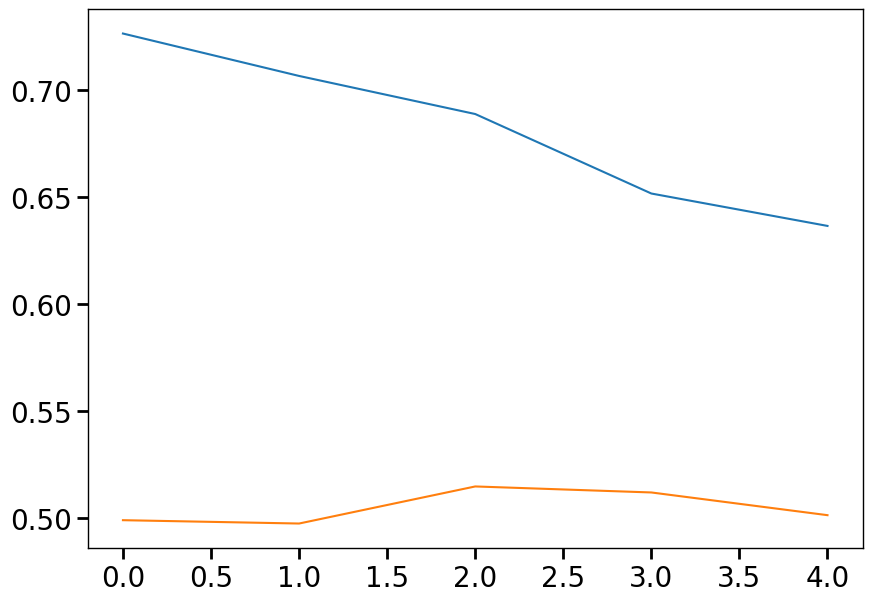

In [6]:
plt.plot(all_block_perf_aligned[all_saved_states['aligned_perturbation']['block_type']==0].mean((0,2)))
plt.plot(all_block_perf_aligned[all_saved_states['aligned_perturbation']['block_type']==1].mean((0,2)))

In [9]:
def stay_probs(results_dict):
    # calculate the probability of staying with the same location and stimulus choice given previous trial's reward outcomes
    # results_dict: dict of results from the model
    # return: dict of stay probabilities
    
    print(results_dict['reward'].shape)

    num_blocks, num_pert, num_trials = results_dict['reward'].shape

    all_block_stay_probs = np.nan*np.empty((num_blocks, num_pert, 4)) # [unrewarded, rewarded] X [loc, img]

    for block_idx in range(num_blocks):
        block_type = results_dict['block_type'][block_idx]

        for pert_idx in range(num_pert):
            reward = results_dict['reward'][block_idx, pert_idx]
            img_chosen = results_dict['img_chosen'][block_idx, pert_idx]
            loc_chosen = results_dict['loc_chosen'][block_idx, pert_idx]

            reward_prev = np.isclose(reward[:-1], 1).squeeze()
            unreward_prev = np.isclose(reward[:-1], 0).squeeze()
            
            all_block_stay_probs[block_idx, pert_idx, 0] = np.mean(loc_chosen[1:][unreward_prev] == loc_chosen[:-1][unreward_prev])
            all_block_stay_probs[block_idx, pert_idx, 1] = np.mean(img_chosen[1:][unreward_prev] == img_chosen[:-1][unreward_prev])
            all_block_stay_probs[block_idx, pert_idx, 2] = np.mean(loc_chosen[1:][reward_prev] == loc_chosen[:-1][reward_prev])
            all_block_stay_probs[block_idx, pert_idx, 3] = np.mean(img_chosen[1:][reward_prev] == img_chosen[:-1][reward_prev])
            
    return all_block_stay_probs


all_block_stay_probs_aligned = stay_probs(all_saved_states['aligned_perturbation'])
all_block_stay_probs_orthogonal = stay_probs(all_saved_states['orthogonal_perturbation'])

(160, 5, 80)
(160, 5, 80)


In [10]:
all_saved_states.shape

AttributeError: 'dict' object has no attribute 'shape'

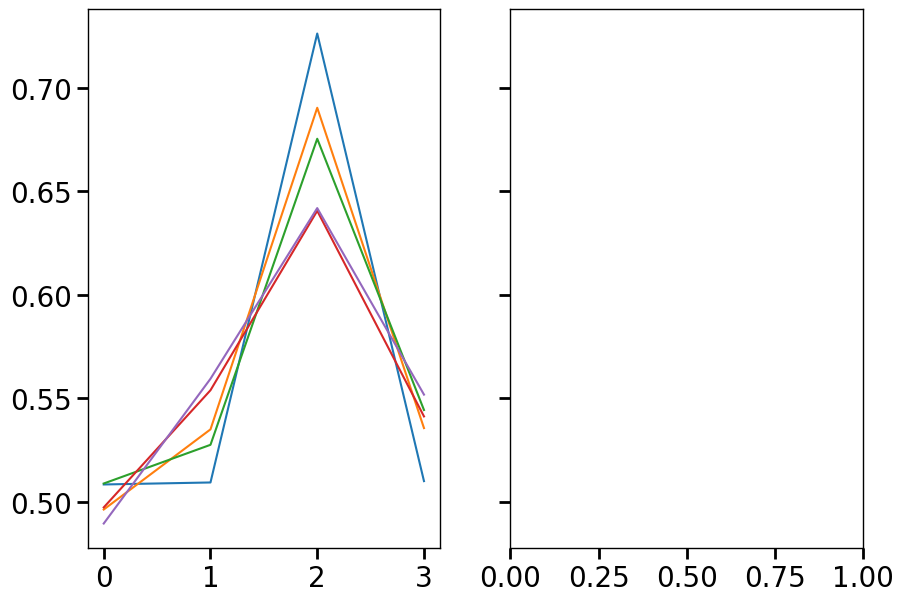

In [12]:
fig, axes = plt.subplots(1,2, sharey=True)

axes[0].plot(all_block_stay_probs_aligned[all_saved_states['aligned_perturbation']['block_type']<2].mean(0).T)
# axes[1].plot(all_block_stay_probs_aligned[all_saved_states['aligned_perturbation']['block_type']==1].mean(0).T)

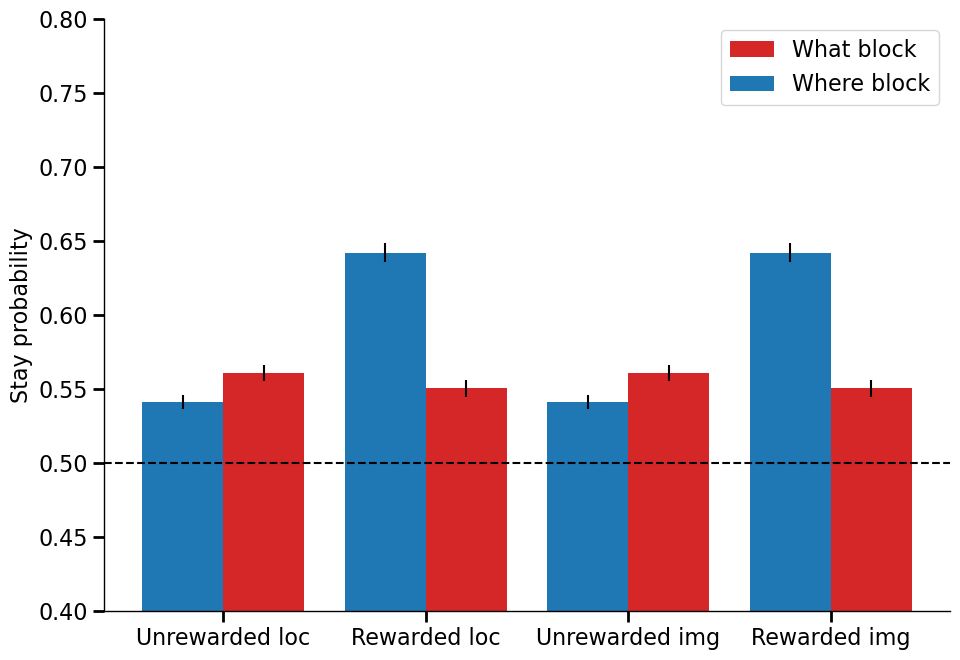

In [9]:
# plot the average stay probabilities in bar plot

stay_probs_what_blocks = [
    [np.mean(all_stay_probs[k]), np.std(all_stay_probs[k])/np.sqrt(len(all_stay_probs[k]))] for k in all_stay_probs.keys() if 'what' in k
]

stay_probs_where_blocks = [
    [np.mean(all_stay_probs[k]), np.std(all_stay_probs[k])/np.sqrt(len(all_stay_probs[k]))] for k in all_stay_probs.keys() if 'where' in k
]

stay_probs_what_blocks = np.array(stay_probs_what_blocks)
stay_probs_where_blocks = np.array(stay_probs_where_blocks)

plt.bar(np.arange(len(stay_probs_what_blocks))+0.2, stay_probs_what_blocks[:,0], color='tab:red', label='What block', width=0.4)
plt.errorbar(np.arange(len(stay_probs_what_blocks))+0.2, stay_probs_what_blocks[:,0], 
             yerr=stay_probs_what_blocks[:,1], color='black', fmt='none')
plt.bar(np.arange(len(stay_probs_where_blocks))-0.2, stay_probs_where_blocks[:,0], color='tab:blue', label='Where block', width=0.4)
plt.errorbar(np.arange(len(stay_probs_where_blocks))-0.2, stay_probs_where_blocks[:,0], 
             yerr=stay_probs_where_blocks[:,1], color='black', fmt='none')
plt.axhline(0.5, ls='--', c='k')

plt.xticks(np.arange(len(stay_probs_what_blocks)), ['Unrewarded loc', 'Rewarded loc', 'Unrewarded img', 'Rewarded img'], fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Stay probability', fontsize=16)
plt.legend(fontsize=16)
plt.ylim([0.4, 0.8])

plt.tight_layout()

sns.despine()

plt.show()






In [10]:
dr_loc_aligned = all_block_stay_probs_aligned[:,2]-all_block_stay_probs_aligned[:,0]
dr_img_aligned = all_block_stay_probs_aligned[:,3]-all_block_stay_probs_aligned[:,1]

dr_loc_orthogonal = all_block_stay_probs_orthogonal[:,2]-all_block_stay_probs_orthogonal[:,0]
dr_img_orthogonal = all_block_stay_probs_orthogonal[:,3]-all_block_stay_probs_orthogonal[:,1]

ValueError: Per-column arrays must each be 1-dimensional

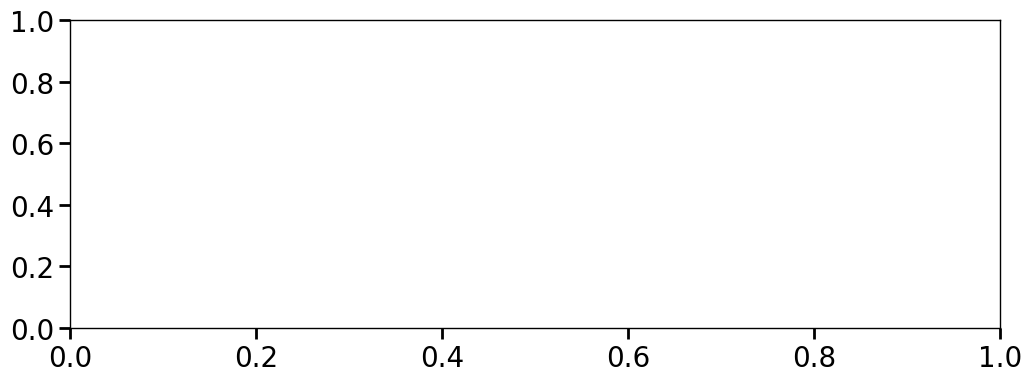

In [13]:

fig, axes = plt.subplots(1,1, sharex=True, sharey=True, figsize=(12, 4))

num_pert_strengths = 5

block_type_mask = all_saved_states['aligned_perturbation']['block_type']>-1
trial_mask = block_type_mask


delta_dr_img_aligned = dr_img_aligned[trial_mask].reshape((-1, num_pert_strengths))
delta_dr_img_aligned -= delta_dr_img_aligned[:,num_pert_strengths//2][:,None]
delta_dr_img_aligned = delta_dr_img_aligned.reshape(-1)

delta_dr_loc_aligned = dr_loc_aligned[trial_mask].reshape((-1, num_pert_strengths))
delta_dr_loc_aligned -= delta_dr_loc_aligned[:,num_pert_strengths//2][:,None]
delta_dr_loc_aligned = delta_dr_loc_aligned.reshape(-1)

xxx = np.concatenate([all_saved_states['aligned_perturbation']['perturbation_strength'][trial_mask], 
                      all_saved_states['aligned_perturbation']['perturbation_strength'][trial_mask]])

yyy = np.concatenate([delta_dr_img_aligned, delta_dr_loc_aligned])

hue = ['Img']*delta_dr_img_aligned.shape[0]+['Loc']*delta_dr_loc_aligned.shape[0]

sns.pointplot(x=xxx, y=yyy, hue=hue, ax=axes,
             palette=['tab:red', 'tab:blue'], estimator='mean', errorbar='se',
             native_scale=True)
#     sns.violinplot(x=xxx, y=yyy, hue=hue, ax=axes[phase-1], legend=False, 
#                    palette=['tab:red', 'tab:blue'], split=True)

print(stats.spearmanr(all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask],
                     delta_dr_img_aligned),
     stats.spearmanr(all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask],
                     delta_dr_loc_aligned),)

delta_dr_img_orthogonal = dr_img_orthogonal[trial_mask].reshape((-1, num_pert_strengths))
delta_dr_img_orthogonal -= delta_dr_img_orthogonal[:,num_pert_strengths//2][:,None]
delta_dr_img_orthogonal = delta_dr_img_orthogonal.reshape(-1)

delta_dr_loc_orthogonal = dr_loc_orthogonal[trial_mask].reshape((-1, num_pert_strengths))
delta_dr_loc_orthogonal -= delta_dr_loc_orthogonal[:,num_pert_strengths//2][:,None]
delta_dr_loc_orthogonal = delta_dr_loc_orthogonal.reshape(-1)

xxx = np.concatenate([all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask], 
                      all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask]])

yyy = np.concatenate([delta_dr_img_orthogonal, delta_dr_loc_orthogonal])

#     sns.pointplot(x=xxx, y=yyy, hue=hue, ax=axes[phase-1], legend=False, 
#                    palette=['grey', 'lightgrey'], errorbar='se', native_scale=True)

print(stats.spearmanr(all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask],
                     delta_dr_img_orthogonal),
     stats.spearmanr(all_saved_states['orthogonal_perturbation']['perturbation_strength'][trial_mask],
                     delta_dr_loc_orthogonal),)


axes[phase-1].set_ylabel(r'$\Delta$ DR')
axes[phase-1].set_xlabel('Perturbation strength')
axes[phase-1].set_title(phase_names[phase-1])
    
    
sns.move_legend(axes[0], "lower right", bbox_to_anchor=(1.0,-0.05), 
                columnspacing=1, handletextpad=0.2, ncols=2)    

sns.despine()
fig.tight_layout()
# plt.savefig(os.path.join(figure_data_dir, "RNN_perturb_block_type.pdf"), bbox_inches='tight')


In [ ]:

# plot perturbed omega projections 
# plot performance by block type and perturbation strength


